In this example, we will use Pyreal to find the top contributing features in the Student Performance dataset.

Data source:

P. Cortez and A. Silva. Using Data Mining to Predict Secondary School Student Performance. In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7.


In [1]:
### Imports
import pandas as pd
import numpy as np
import sys

First, we load in the data, and provide human-readable descriptions of every feature. These descriptions will make the resulting explanations much more user friendly.

In [2]:
feature_descriptions = {
    "school":"School",
    "sex":"Sex",
    "age":"Age",
    "address":"Address type",
    "famsize":"Family size",
    "Pstatus":"Parent's cohibition status",
    "Medu":"Mother's education",
    "Fedu":"Father's education",
    "Mjob":"Mother's job",
    "Fjob":"Father's job",
    "reason":"Reason for choosing this school",
    "guardian":"Student's guardian",
    "traveltime":"Home to school travel time",
    "studytime":"Weekly study time",
    "failures":"Number of past class failures",
    "schoolsup":"Extra education support",
    "famsup":"Family eductional support",
    "paid":"Extra paid classes within the subject",
    "activities":"Extra-curricular activities",
    "nursery":"Attended nursery school",
    "higher":"Wants to take higher education",
    "internet":"Has internet at home",
    "romantic":"In a romantic relationship",
    "famrel":"Quality of family relationships (1-5)",
    "freetime":"Amount of free time after school (1-5)",
    "goout":"Frequency of going out with friends (1-5)",
    "Dalc":"Frequency of workday alcohol consumption (1-5)",
    "Walc":"Frequency of workday alcohol consumption (1-5)",
    "health":"Current health status (1-5)",
    "absences":"Number of school absences"
}

file_path = "student-por.csv"
data_table = pd.read_csv(file_path, sep=";")

Next, we extract our chosen target variable. In this case, we will be predicting whether a student will pass (score > 10).

In [3]:
y = (data_table["G3"]>10).astype(int)

data = data_table.drop(["G1", "G2","G3"], axis='columns')
X = data

Now, we will create the transformers. The first will encode boolean features as integers, the second will one hot encode categorical features, and the first with standardize the data.

Some transformation and explanation type combos require post-hoc transformations on the explanations themselves. In this case, we will run SHAP on the one-hot-encoded features, and then recombine the contributions of these features. The OneHotEncoderWrapper includes this functionality.

In [4]:
from pyreal.transformers import Transformer, OneHotEncoder, DataFrameWrapper
from sklearn.preprocessing import StandardScaler

class BooleanEncoder(Transformer):
    def __init__(self, cols):
        self.cols = cols

    def data_transform(self, x):
        x_transform = x.copy()
        for col in self.cols:
            x_transform[col] = x_transform[col].replace(('yes', 'no'), (1, 0))
        x_transform["famsize"] = x_transform["famsize"].astype('category')
        x_transform["famsize"] = x_transform["famsize"].cat.set_categories(['LE3', 'GT3'])
        x_transform["famsize"] = x_transform["famsize"].cat.reorder_categories(['LE3', 'GT3'])
        x_transform["famsize"] = x_transform["famsize"].cat.codes
        return x_transform

    def inverse_transform_explanation(self, explanation):
        return explanation

onehotencoder = OneHotEncoder(["school", "sex", "address", "Pstatus", "reason", "guardian", "Mjob", "Fjob"])
onehotencoder.fit(data)

boolean_encoder = BooleanEncoder(["schoolsup", "famsup", "paid", "activities", "nursery", "internet", "romantic", "higher"])

standard_scaler = DataFrameWrapper(StandardScaler())
data_for_fitting = boolean_encoder.data_transform(onehotencoder.transform(X))
standard_scaler.fit(data_for_fitting)

In [5]:
from pyreal.explainers import LocalFeatureContribution

transformers = [onehotencoder, boolean_encoder, standard_scaler]
lfc = LocalFeatureContribution(model="model.pkl",
                               x_train_orig=X, transformers=transformers,
                               feature_descriptions=feature_descriptions)

Trying to unpickle estimator LogisticRegression from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


We can test the accuracy of the model

In [6]:
preds = lfc.model_predict(X)
print("Accuracy: %.2f%%" % (np.mean(preds==y)*100))

Accuracy: 81.97%


Finally, we fit our explainer, and take a look at the most predictive features.

In [7]:
lfc.fit()

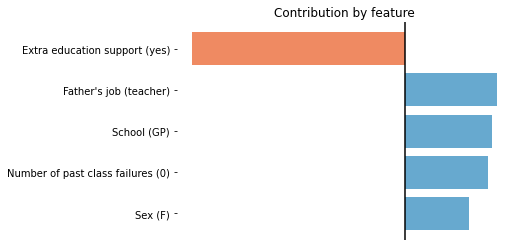

In [8]:
from pyreal.utils import visualize

input_to_explain = X.iloc[0]
contributions = lfc.produce(input_to_explain)
x_interpret = lfc.convert_data_to_interpretable(input_to_explain)

visualize.plot_top_contributors(contributions, select_by="absolute",
                                values=x_interpret, show=True)

We can also generate a global feature importance explanation, that summarizes the overall importance of features across all inputs.

Trying to unpickle estimator LogisticRegression from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator LogisticRegression from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


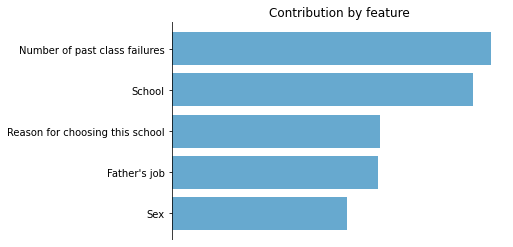

In [9]:
from pyreal.explainers import GlobalFeatureImportance

gfi = GlobalFeatureImportance(model="model.pkl",
                              x_train_orig=X, transformers=transformers,
                              feature_descriptions=feature_descriptions,
                              fit_on_init=True)

importances = gfi.produce(input_to_explain)
visualize.plot_top_contributors(importances, select_by="absolute",
                                show=True)